In [8]:
from SCA_classes import Segmentation_Collision_Avoidance, Debug_Timer
import numba_functs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import cv2
import time
import yaml
from ultralytics import FastSAM
from collections import defaultdict
from shapely.geometry import Point, Polygon
from numba import njit, prange
from timeit import default_timer as timer
from PIL import Image

In [9]:
with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
dt = Debug_Timer(True)
sca = Segmentation_Collision_Avoidance(config, dt)

In [10]:
# for i in range(10):
#     dt.start("add_image_file")
#     sca.add_CARLA_image_file("1080p" + str(i + 40))
#     dt.stop("add_image_file")

# for i in range(6):
#     dt.start("add_image_file")
#     sca.add_OAKD_image_file(str(i + 73))
#     dt.stop("add_image_file")

for i in range(6): # 2, 6
    dt.start("add_image_file")
    sca.add_OAKD_image_file("2_" + str(i + 69))
    dt.stop("add_image_file")


0: 384x640 95 objects, 43.1ms
Speed: 1.5ms preprocess, 43.1ms inference, 43.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 90 objects, 57.3ms
Speed: 1.6ms preprocess, 57.3ms inference, 43.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 85 objects, 64.0ms
Speed: 1.5ms preprocess, 64.0ms inference, 43.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 73 objects, 54.2ms
Speed: 1.6ms preprocess, 54.2ms inference, 38.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 59 objects, 52.7ms
Speed: 1.6ms preprocess, 52.7ms inference, 34.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 38 objects, 51.8ms
Speed: 1.6ms preprocess, 51.8ms inference, 24.7ms postprocess per image at shape (1, 3, 384, 640)


In [11]:
dt.print_all()

open_img:
	avg = 0.012214137241244316, min = 0.010764196049422026, max = 0.01994072599336505
	total = 0.0732848234474659, 6 samples
fastSAM:
	avg = 0.15546592425865433, min = 0.1270775436423719, max = 0.21499050268903375
	total = 0.9327955455519259, 6 samples
make_cartesian:
	avg = 0.47515740680197877, min = 0.474572385661304, max = 0.480885474011302
	total = 2.8509444408118725, 6 samples
add_image_file:
	avg = 0.7913153037273636, min = 0.7226855223998427, max = 0.8843057481572032
	total = 4.747891822364181, 6 samples


In [ ]:
frame_idx = 1
window = sca.predictor.window
frame = window.frames[frame_idx]

In [ ]:
# plt.imshow(frame.cartImg[:,:,0])
# plt.figure()
# plt.imshow(frame.cartImg[:,:,1])
# # obj_idx = 2 # 0, 0, 3
# window = sca.predictor.window
# frame = window.frames[frame_idx]
# obj = window.objects_in_scope[frame_idx][obj_idx]
# rgbImg = np.copy(frame.rgbImg)
# depthImg = np.copy(frame.depthImg)
# for i in range(3):
#     rgbImg[:,:,i] = np.where(obj.segMask, rgbImg[:,:,i], np.nan)
# depthImg[:,:] = np.where(obj.segMask, depthImg[:,:], np.nan)
# plt.imshow(rgbImg)
# plt.figure()
# plt.imshow(depthImg)
# nan_area = np.sum(np.logical_not(np.isnan(depthImg)))
# print(nan_area / obj.area)
# print(len(window.objects_in_scope[0]))

10.008782


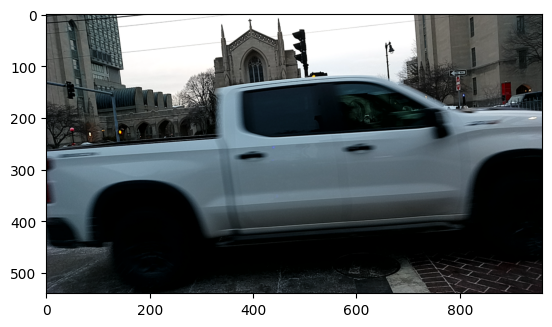

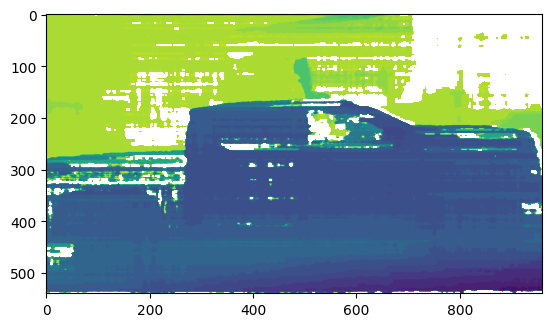

In [14]:
plt.imshow(sca.predictor.window.frames[frame_idx].rgbImg)
plt.figure()
plt.imshow(sca.predictor.window.frames[frame_idx].depthImg)
print(np.nanmax(sca.predictor.window.frames[frame_idx].depthImg[:,:]))

/tmp/ipykernel_3944918/3253097675.py:7: RuntimeWarning: invalid value encountered in cast
  rgbImg[:,:,i] = np.where(obj.segMask, rgbImg[:,:,i], np.nan)


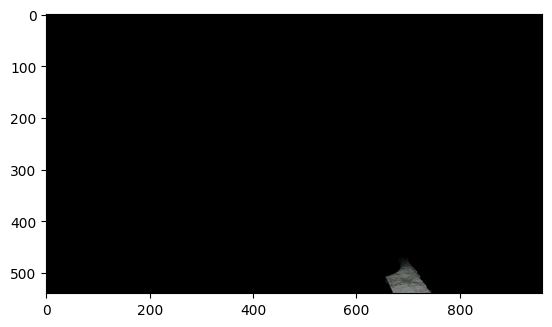

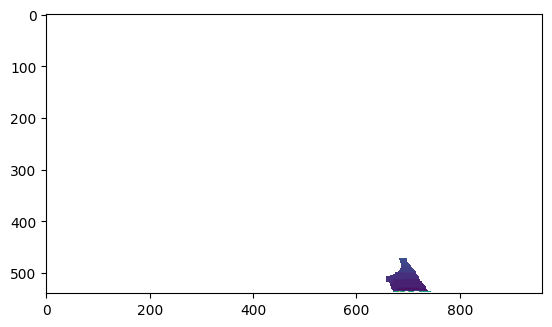

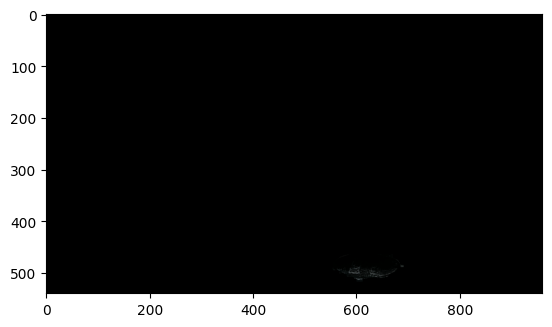

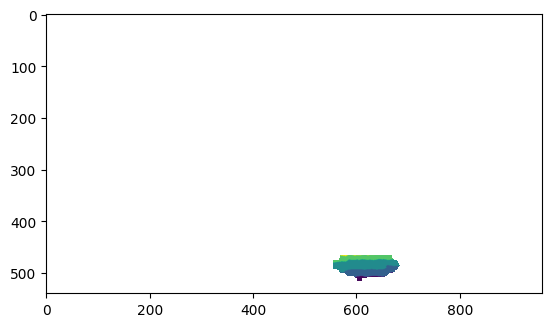

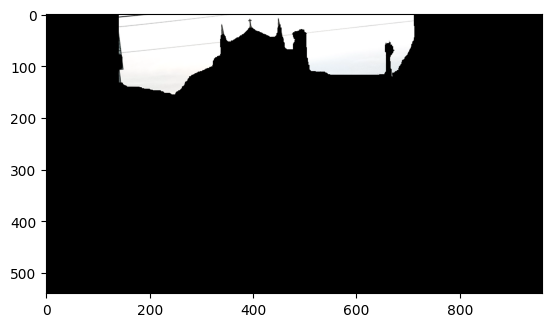

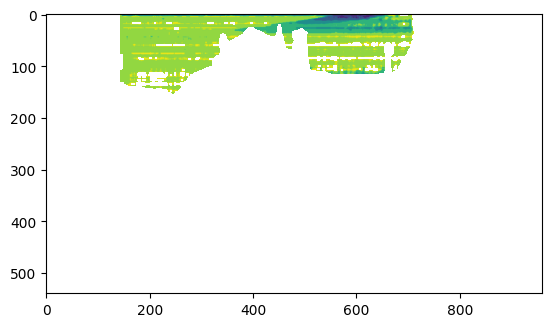

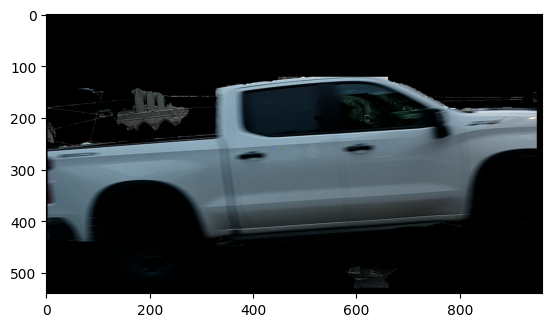

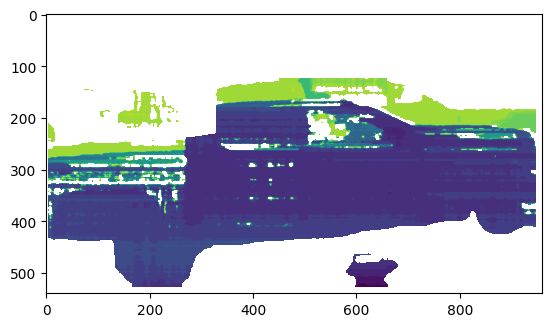

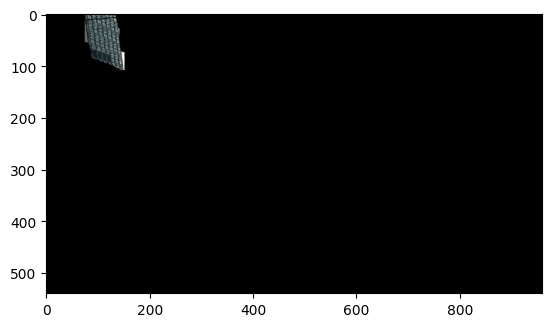

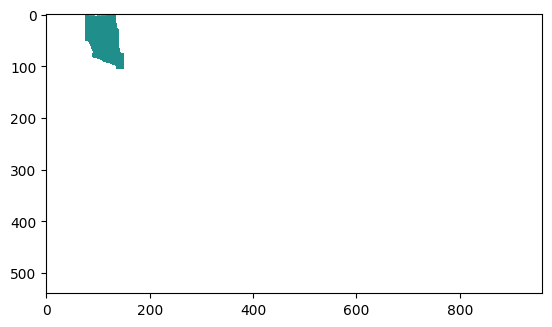

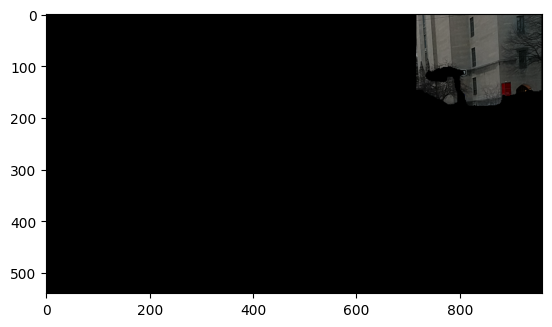

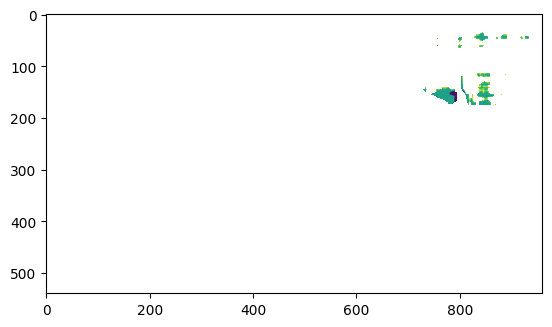

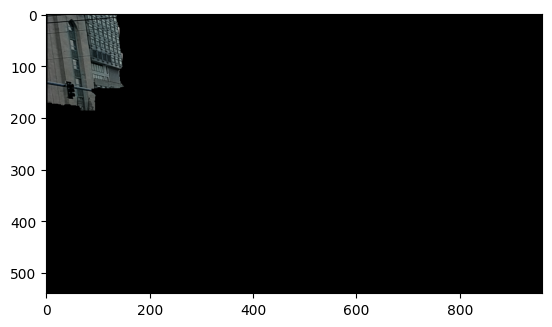

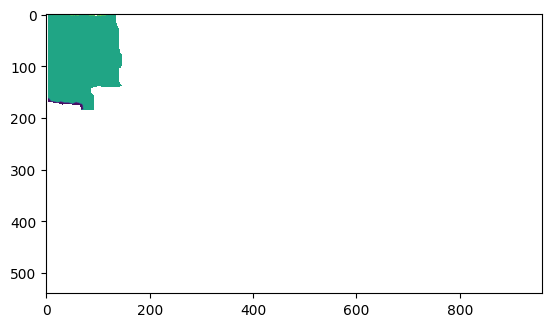

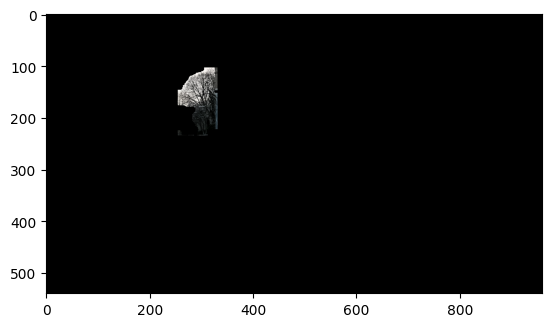

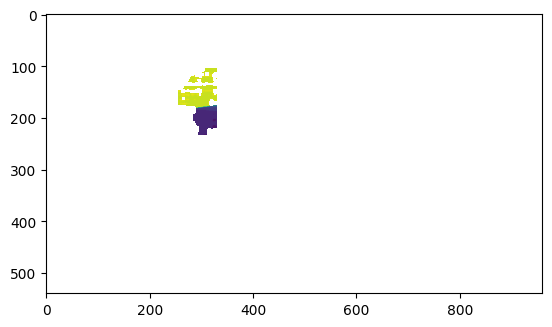

In [15]:
window = sca.predictor.window
frame = window.frames[frame_idx]
for obj in window.objects_in_scope[frame_idx]:
    rgbImg = np.copy(frame.rgbImg)
    depthImg = np.copy(frame.depthImg)
    for i in range(3):
        rgbImg[:,:,i] = np.where(obj.segMask, rgbImg[:,:,i], np.nan)
    depthImg[:,:] = np.where(obj.segMask, depthImg[:,:], np.nan)
    plt.figure()
    plt.imshow(rgbImg)
    plt.figure()
    plt.imshow(depthImg)